Importing Necessary Libraries

In [1]:
# Data manipulation and handling libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

# Data preprocessing and EDL Libraries
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

# Model Selection libraries
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV

# ML Models
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
import xgboost
from xgboost import XGBRFRegressor

# Model Evaluation
from sklearn.metrics import r2_score,mean_squared_error

# Warning filter library
import warnings
warnings.filterwarnings("ignore")

# Loading the Dataframe
df=pd.read_excel('Capstone Project.xlsx')

# Multi-Collinearity test and treatment libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [2]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


#Exploratory Data Analysis (EDA)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Observations from df.info()
1) There are no null values
2) We have 1030 rows and 9 columns
3) Dependent variable = Strength
4) Rest of all columns are independent variable

In [4]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Analysis from descriptive statistics
1) There might be skewness in the data in all columns
2) There might be chances of outliers if we compare quartile of some columns
3) Since minimum and q1 values are same for slag and ash, so we do not have outliers in the lower whisker region
4) The range of the value 'age' is from 1 to 365. We can say that the values are in 'days'


In [5]:
def custom_summary(my_df):
    result = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            stats = OrderedDict({
                'feature_name':col,
                'count':my_df[col].count(),
                'quartile1':my_df[col].quantile(.25),
                'quartile2':my_df[col].quantile(.50),
                'quartile3':my_df[col].quantile(.75),
                'mean':my_df[col].mean(),
                'max':my_df[col].max(),
                'variance':round(my_df[col].var()),
                'standard_deviation':my_df[col].std(),
                'skewness':my_df[col].skew(),
                'kurtosis':my_df[col].kurt() 
            })

        result.append(stats)
    result_df=pd.DataFrame(result)
    
    #skewness type
    skewness_label =[]
    for i in result_df['skewness']:
        if i <= -1:
            skewness_label.append('Highly negatively skewed')
        elif -1 < i <= -0.5:
            skewness_label.append('Moderately negatively skewed')
        elif -0.5 < i < 0:
            skewness_label.append('Fairly negatively skewed')
        elif 0 <= i <= 1:
            skewness_label.append('Fairly Positively skewed')
        elif 0.5 <= i < 1:
            skewness_label.append('Moderately Positively skewed')
        elif i >= 1:
            skewness_label.append('Highly Positively skewed')
    result_df['skewness_comment'] = skewness_label
    
    #kurtosis type:
    kurtosis_label = []
    for i in result_df['kurtosis']:
        if i >= 1:
            kurtosis_label.append('Leptokurtic Curve')
        elif i <= 1:
            kurtosis_label.append('Platykurtic Curve')
        else:
            kurtosis_label.append('Mesokurtic Curve')
    
    result_df['kurtosis_comment'] = kurtosis_label
    
    #outliers
    outliers_label = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            q1 = my_df[col].quantile(.25)
            q2 = my_df[col].quantile(.50)
            q3 = my_df[col].quantile(.75)
            iqr = q3 - q1
            lower_whisker = q1-1.5*iqr
            upper_whisker = q3+1.5*iqr
            if len(my_df[(my_df[col] < lower_whisker) | (my_df[col] > upper_whisker) ]) > 0:
                outliers_label.append('Have outliers')
            else:
                outliers_label.append('No outliers')
    result_df['Outlier Comment'] = outliers_label
    return result_df

In [6]:
custom_summary(df)

,feature_name,count,quartile1,quartile2,quartile3,mean,max,variance,standard_deviation,skewness,kurtosis,skewness_comment,kurtosis_comment,Outlier Comment
0,cement,1030,192.375,272.900,350.000,281.167864,540.0,10922,104.506364,0.509481,-0.520652,Fairly Positively skewed,Platykurtic Curve,No outliers
1,slag,1030,0.000,22.000,142.950,73.895825,359.4,7444,86.279342,0.800717,-0.508175,Fairly Positively skewed,Platykurtic Curve,Have outliers
2,ash,1030,0.000,0.000,118.300,54.188350,200.1,4096,63.997004,0.537354,-1.328746,Fairly Positively skewed,Platykurtic Curve,No outliers
3,water,1030,164.900,185.000,192.000,181.567282,247.0,456,21.354219,0.074628,0.122082,Fairly Positively skewed,Platykurtic Curve,Have outliers
4,superplastic,1030,0.000,6.400,10.200,6.204660,32.2,36,5.973841,0.907203,1.411269,Fairly Positively skewed,Leptokurtic Curve,Have outliers
5,coarseagg,1030,932.000,968.000,1029.400,972.918932,1145.0,6046,77.753954,-0.040220,-0.599016,Fairly negatively skewed,Platykurtic Curve,No outliers
6,fineagg,1030,730.950,779.500,824.000,773.580485,992.6,6428,80.175980,-0.253010,-0.102177,Fairly negatively skewed,Platykurtic Curve,Have outliers
7,age,1030,7.000,28.000,56.000,45.662136,365.0,3990,63.169912,3.269177,12.168989,Highly Positively skewed,Leptokurtic Curve,Have outliers
8,strength,1030,23.710,34.445,46.135,35.817961,82.6,279,16.705742,0.416977,-0.313725,Fairly Positively skewed,Platykurtic Curve,Have outliers


#Analysis from custom summary

1. Cement has a mesokurtic curve which implies the data points are moderate in distance from the mean, so mean and standard deviation are moderate.
2. Slag has a mesokurtic curve which implies the data points are moderate from the mean, so mean and standard deviation are moderate.
3. Ash has a platykurtic curve which implies the mean does not represent the whole data properly, so standard deviation is high.
4. Water has a mesokurtic curve which implies the data points are moderate in distance from the mean, so mean and standard deviation are moderate.
5. Superplastic has a leptokurtic curve which implies the datapoints are closer to mean, so mean is quite good.

In [7]:
#Performing Outlier Treatment
def replace_outlier(my_df,col,method='quartile',strategy='median'):
    col_data=my_df[col]
    
    if method=='quartile':
        #using quartile to calculate iqr
        q1=my_df[col].quantile(.25)
        q2=my_df[col].quantile(.50)
        q3=my_df[col].quantile(.75)
        iqr=q3-q1
        lower_whisker=q1-1.5*iqr
        upper_whisker=q3+1.5*iqr
    
    elif method=='standard deviation':
        mean=col_data.mean()
        std=col_data.std()
        lower_whisker=mean-2*std
        uppper_whisker=mean+2*std
    
    else:
        print("Pass a correct method")
        
    #printing all the outliers
    
    outliers=my_df.loc[(col_data<lower_whisker) | (col_data>upper_whisker)]
    outliers_density=round(len(outliers)/len(my_df),2)*100
    if len(outliers) == 0:
        print(f'Feature {col} does not have outliers')
        print("\n")
    else:
        print(f'Feature {col} has outliers')
        print("\n")
        print(f'Total number of outliers in {col} are {len(outliers)}')
        print("\n")
        print(f'Outlier percentage in {col} is {outliers_density}%')
        print("\n")
        display(my_df[(col_data<lower_whisker) | (col_data>upper_whisker)]) 
        
    #replacing outliers
    if strategy =='median':
        my_df.loc[(col_data<lower_whisker)|(col_data>upper_whisker),col]=q2
    elif strategy=='mean':
        my_df.loc[(col_data<lower_whisker)|(col_data>upper_whisker),col]=mean
    else:
        print("Pass a correct startegy")
    
    return my_df

In [8]:
replace_outlier(df,"slag")

Feature slag has outliers


Total number of outliers in slag are 2


Outlier percentage in slag is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
918,239.6,359.4,0.0,185.7,0.0,941.6,664.3,28,39.44
990,239.6,359.4,0.0,185.7,0.0,941.6,664.3,7,25.42


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06


#ODT (Outlier Detection Technique)
1. Descriptive Plots
2. Histogram with Outliers
3. Histogram without Outliers

In [9]:
def odt_plots(my_df,col):
    f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(25,8))
    
    #Descriptive Statistics Box Plot
    sns.boxplot(my_df[col],ax=ax1)
    ax1.set_title(col+"Box Plot")
    ax1.set_xlabel("Values")
    ax1.set_ylabel("Box Plot")
    
    #Plotting Histogram with Outliers
    sns.distplot(my_df[col],ax=ax2,fit=sci.norm) #Histplot and Displot same output
    ax2.axvline(my_df[col].mean(),color='green')
    ax2.axvline(my_df[col].median(),color='brown')
    ax2.set_title(col+"Histogram with Outliers")
    ax2.set_xlabel("Values")
    ax2.set_ylabel("Density")
    
    #Replacing Outliers
    df_out=replace_outlier(my_df,col)
    
    #Plotting Histogram without Outliers
    sns.distplot(my_df[col],ax=ax3,fit=sci.norm) #Histplot and Displot same output
    ax3.axvline(my_df[col].mean(),color='green')
    ax3.axvline(my_df[col].median(),color='brown')
    ax3.set_title(col+"Histogram with Outliers")
    ax3.set_xlabel("Values")
    ax3.set_ylabel("Density")
    
    plt.show() 
    

Feature cement does not have outliers




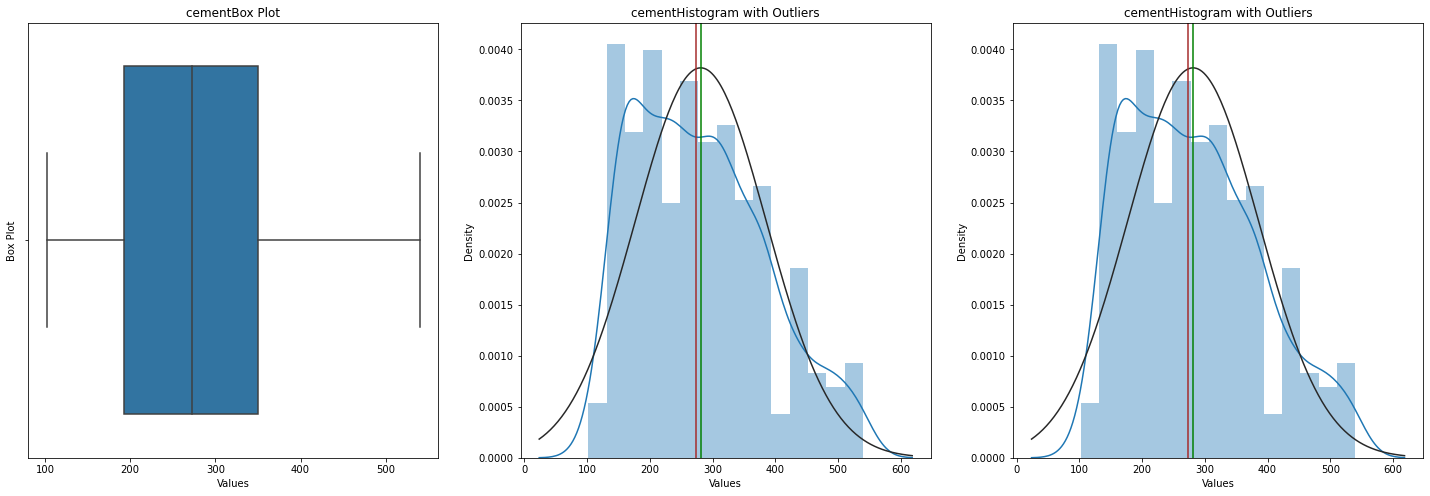

Feature slag does not have outliers




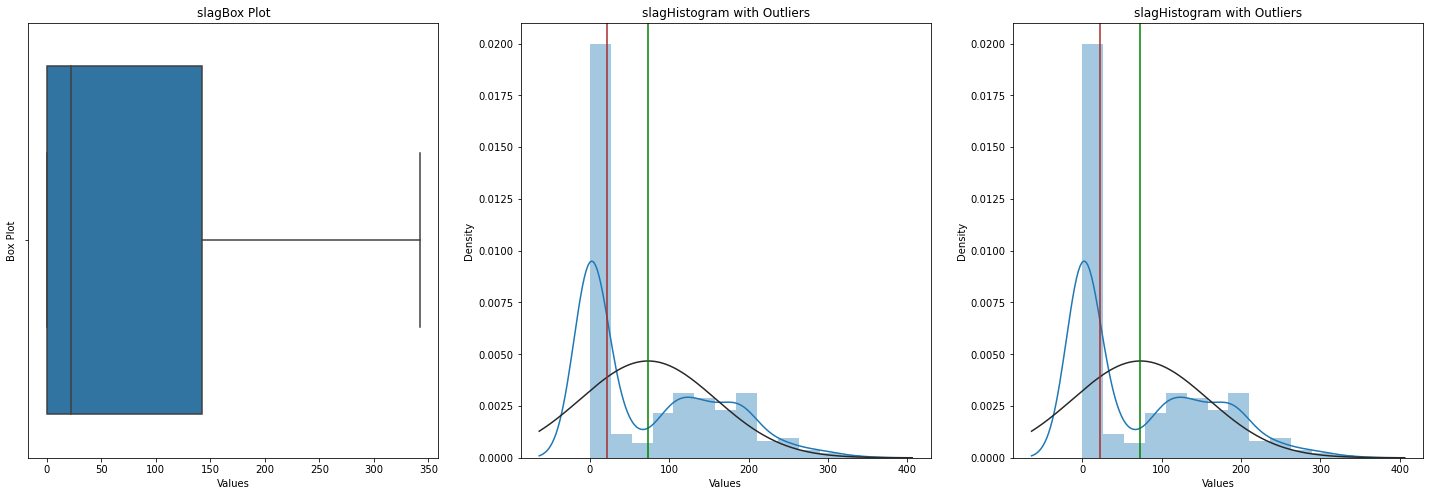

Feature ash does not have outliers




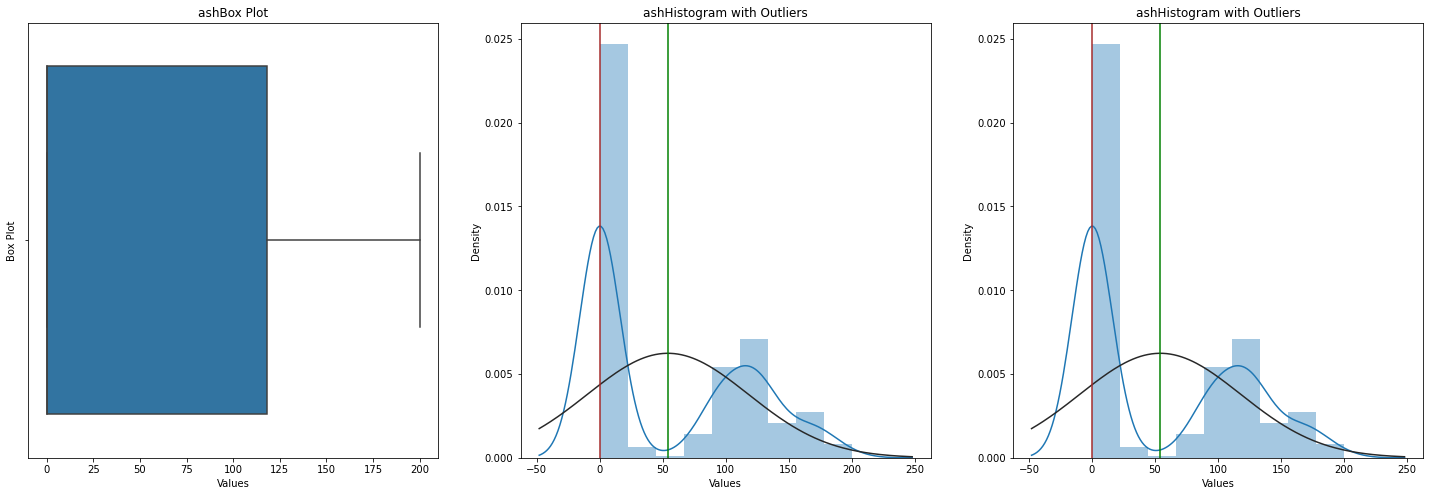

Feature water has outliers


Total number of outliers in water are 9


Outlier percentage in water is 1.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
66,237.0,92.0,71.0,247.0,6.0,853.0,695.0,28,28.63
263,236.9,91.7,71.5,246.9,6.0,852.9,695.4,28,28.63
432,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,28,24.24
462,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,100,39.23
587,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,3,7.75
740,140.0,164.0,128.0,237.0,6.0,869.0,656.0,28,35.23
789,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,56,32.85
826,139.7,163.9,127.7,236.7,5.8,868.6,655.6,28,35.23
914,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,14,17.82


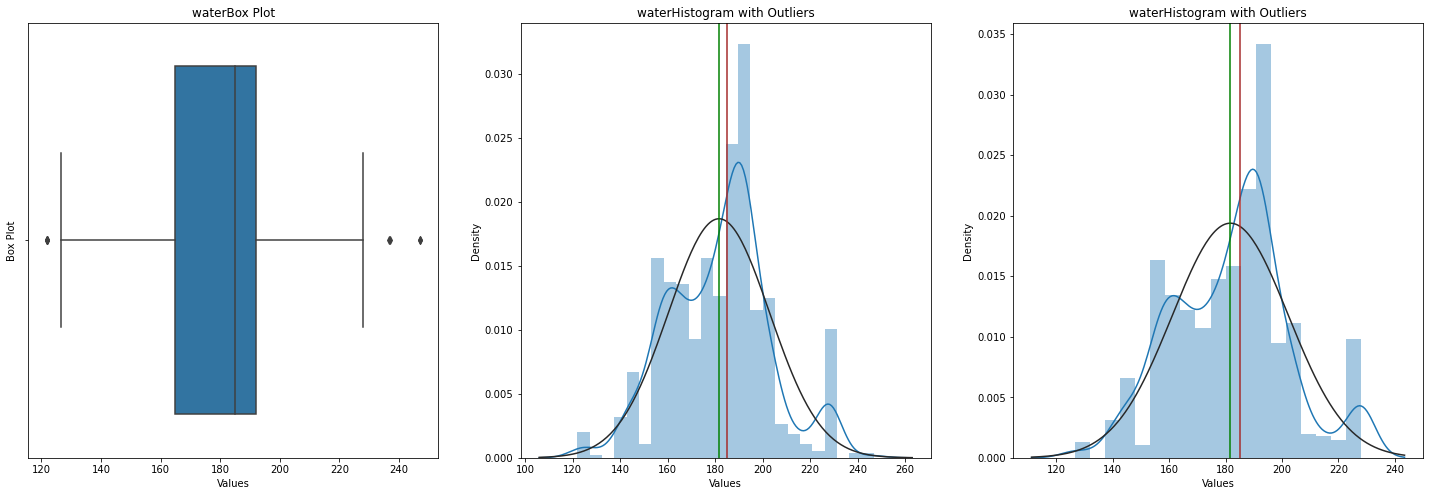

Feature superplastic has outliers


Total number of outliers in superplastic are 10


Outlier percentage in superplastic is 1.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91,59.2
156,531.3,0.0,0.0,141.8,28.2,852.1,893.7,28,56.4
232,469.0,117.2,0.0,137.8,32.2,852.1,840.5,56,69.3
292,469.0,117.2,0.0,137.8,32.2,852.1,840.5,91,70.7
538,531.3,0.0,0.0,141.8,28.2,852.1,893.7,7,46.9
744,469.0,117.2,0.0,137.8,32.2,852.1,840.5,7,54.9
816,469.0,117.2,0.0,137.8,32.2,852.1,840.5,28,66.9
838,531.3,0.0,0.0,141.8,28.2,852.1,893.7,56,58.8
955,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,40.2
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.3


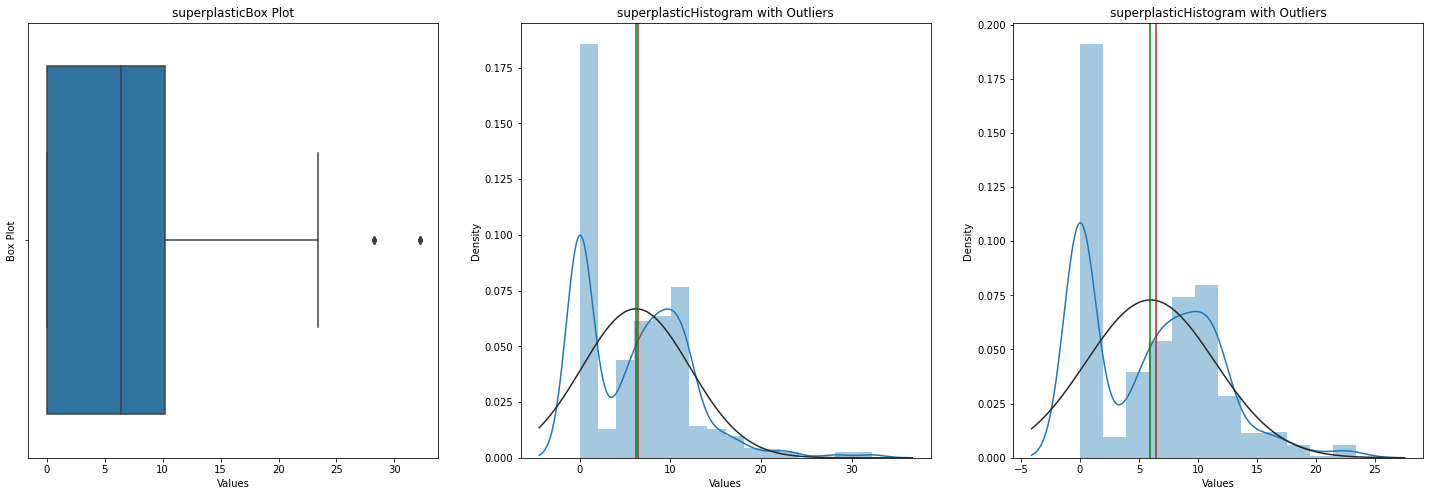

Feature coarseagg does not have outliers




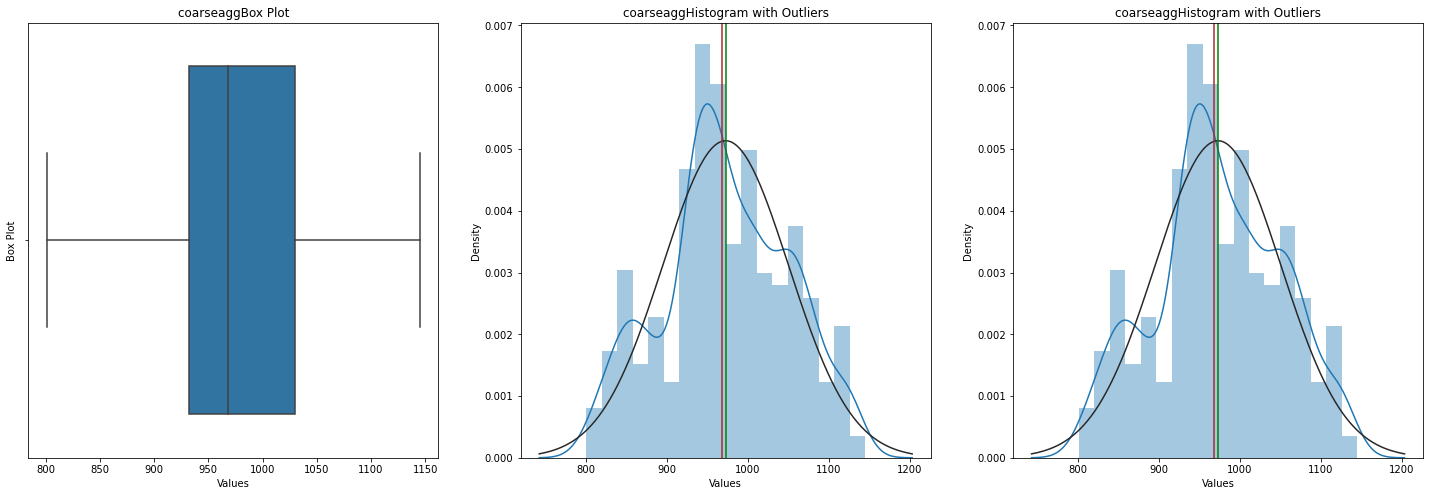

Feature fineagg has outliers


Total number of outliers in fineagg are 5


Outlier percentage in fineagg is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
129,375.0,93.8,0.0,126.6,23.4,852.1,992.6,91,62.5
447,375.0,93.8,0.0,126.6,23.4,852.1,992.6,7,45.7
504,375.0,93.8,0.0,126.6,23.4,852.1,992.6,3,29.0
584,375.0,93.8,0.0,126.6,23.4,852.1,992.6,56,60.2
857,375.0,93.8,0.0,126.6,23.4,852.1,992.6,28,56.7


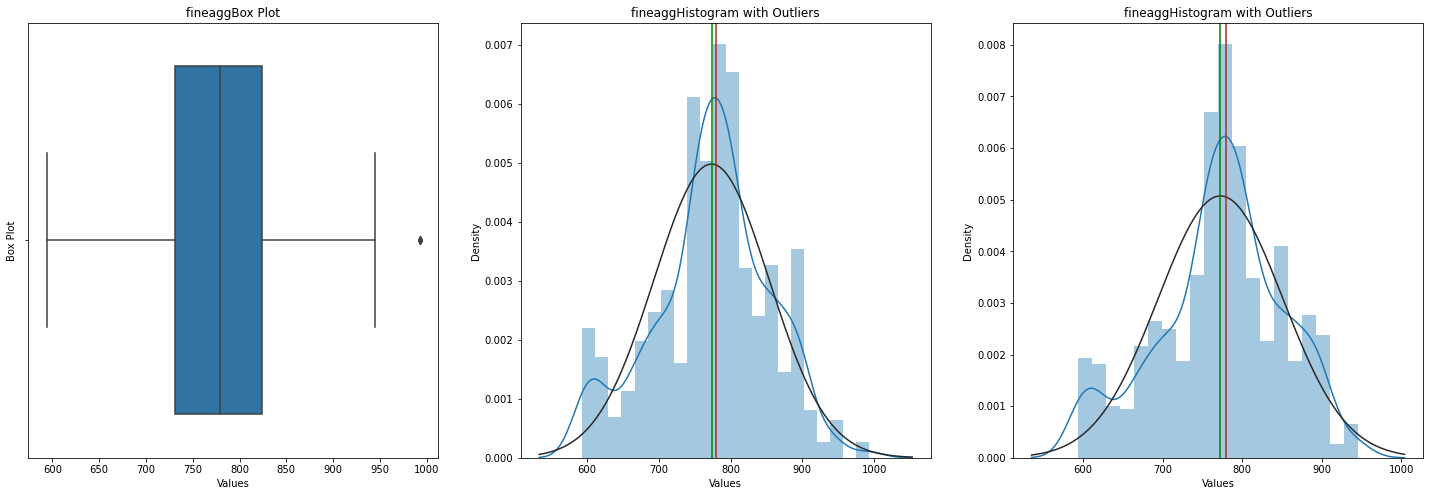

Feature age has outliers


Total number of outliers in age are 59


Outlier percentage in age is 6.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
51,331.0,0.0,0.0,192.0,0.0,978.0,825.0,180,39.00
64,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
93,427.5,47.5,0.0,228.0,0.0,932.0,594.0,180,41.84
99,237.5,237.5,0.0,228.0,0.0,932.0,594.0,180,36.25
103,380.0,0.0,0.0,228.0,0.0,932.0,670.0,180,53.10
133,236.0,0.0,0.0,193.0,0.0,968.0,885.0,365,25.08
144,302.0,0.0,0.0,203.0,0.0,974.0,817.0,180,26.74
149,380.0,95.0,0.0,228.0,0.0,932.0,594.0,270,41.15
152,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,29.59
157,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


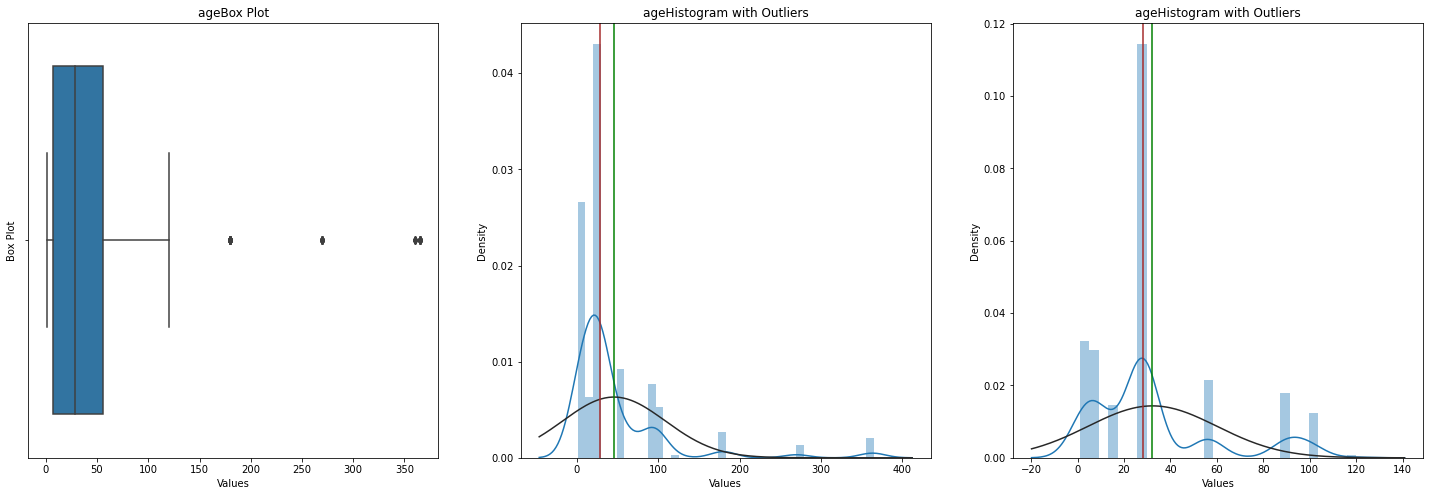

Feature strength has outliers


Total number of outliers in strength are 4


Outlier percentage in strength is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
192,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28,81.75
732,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
950,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91,82.60
1003,323.7,282.8,0.0,183.8,10.3,942.7,659.9,56,80.20


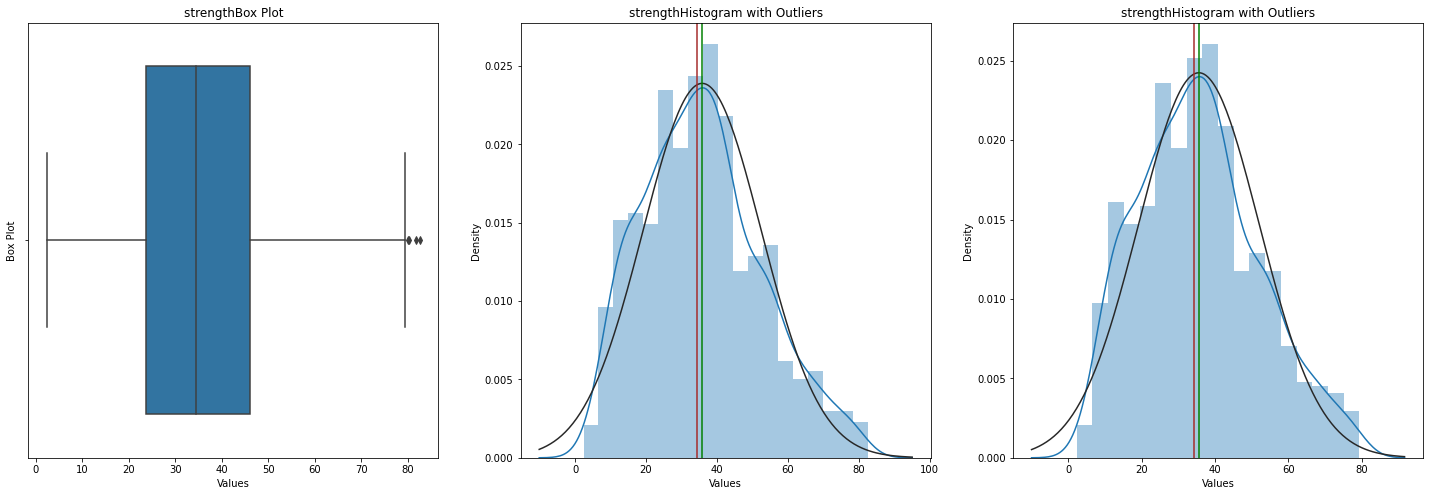

In [10]:
for col in df.columns:
    odt_plots(df,col)

#Multivariate Analysis using Regression

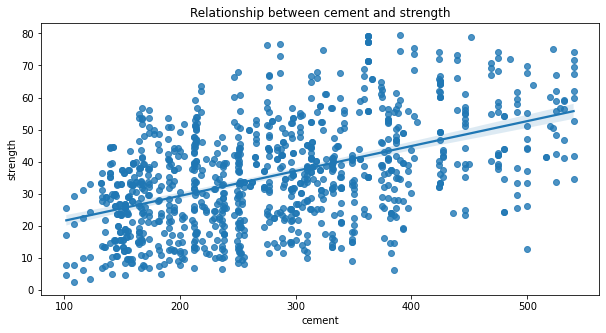

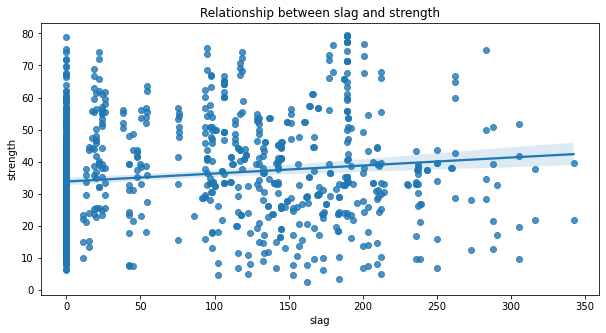

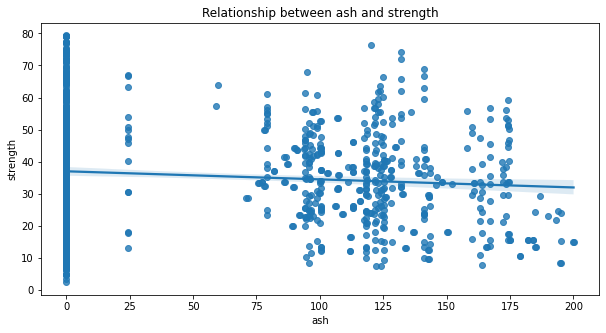

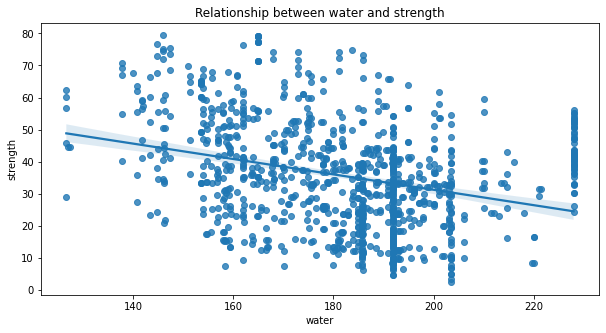

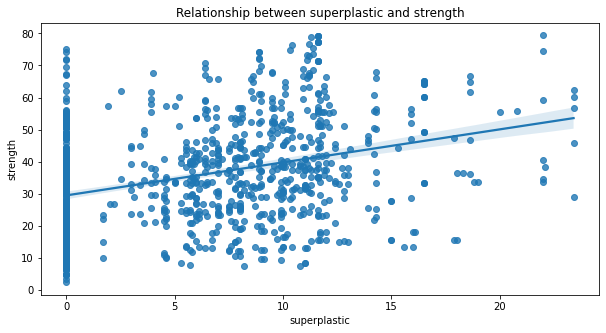

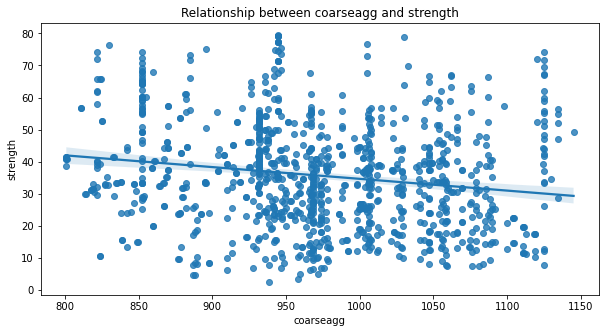

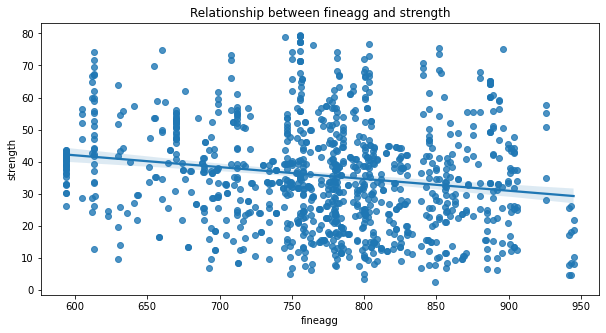

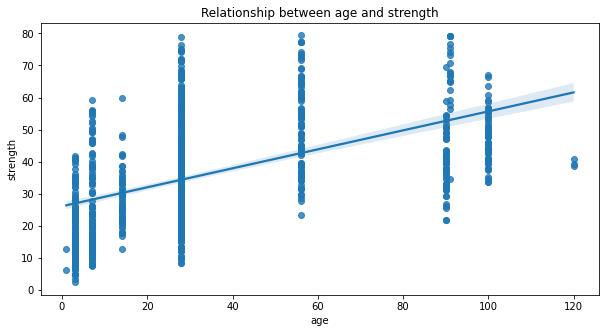

In [11]:
for col in df.columns:
    if col !='strength':
        fig,ax1=plt.subplots(figsize=(10,5))
        sns.regplot(x=df[col],y=df['strength'],ax=ax1).set_title(f'Relationship between {col} and strength')
        

Analysis from Regression Plot
1. Strength and Cement are highly positively correlated
2. Slag and Strength are slightly positively correlated
3. Strength and Ash are slightly negatively correlated
4. Water and Strength are highly negatively correlated
5. Superplastic and Strength are highly positively correlated

#Multi collinearity test

<AxesSubplot:>

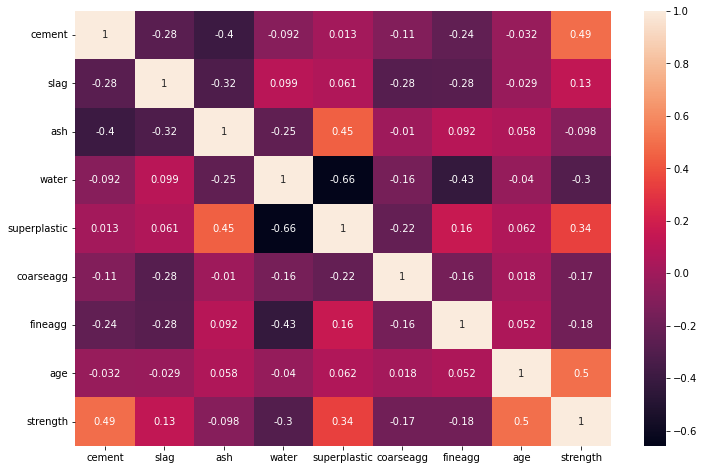

In [12]:
corr=df.corr()
df.ax=plt.subplots(figsize=(12,8))
sns.heatmap(corr,annot=True)

Analysis from stage1 test
1. Cement has high correlation with strength (0.49)
2. Slag has high correlation with ash
3. Ash has high correlation with cement

#Multi collinearity test
1. VIF (Variance Inflation Factor) 

#Correlation with target feature

In [13]:
def correlation_with_target(data,t_col):
    independent_variable=data.drop(t_col,axis=1).columns
    corr_result=[]
    for col in independent_variable:
        corr_result.append(data[t_col].corr(data[col]))
    result=pd.DataFrame([independent_variable,corr_result],index=['Independent variables','Correlation']).T
    return result.sort_values('Correlation',ascending=False)

In [14]:
correlation_with_target(df,'strength')

,Independent variables,Correlation
7,age,0.499711
0,cement,0.493518
4,superplastic,0.342633
1,slag,0.129561
2,ash,-0.097973
5,coarseagg,-0.173234
6,fineagg,-0.176113
3,water,-0.300043


In [15]:
def custom_PCA(X):
    n_comp=len(X.columns)
    
# Applying StandardScaler for feature scaling (Feature Scaling Technique)
    sc=StandardScaler()
    X=sc.fit_transform(X)
    for i in range(1,n_comp):
        pca=PCA(n_components=i)
        p_comp=pca.fit_transform(X)
        evr=np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1]>0.9:
            pcs=i
            break
    print("Explained Variance Ratio after PCA is: ",evr)
    # Creating a dataframe pf principal components
    col=[]
    for j in range(1,pcs+1):
        col.append("PC_"+str(j))
    pca_df=pd.DataFrame(p_comp,columns=col)
    return pca_df   

In [16]:
pca_df=custom_PCA(df.drop("strength",axis=1))

Explained Variance Ratio after PCA is:  [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


#94% of the information we are retaining (before StandardScaler)
#97% of the information we are retaining (afer StandardScaler)

In [17]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


#Joining PCA features with target features

In [18]:
pca_df=pca_df.join(df["strength"],how="left")

In [19]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PC_1      1030 non-null   float64
 1   PC_2      1030 non-null   float64
 2   PC_3      1030 non-null   float64
 3   PC_4      1030 non-null   float64
 4   PC_5      1030 non-null   float64
 5   PC_6      1030 non-null   float64
 6   strength  1030 non-null   float64
dtypes: float64(7)
memory usage: 56.5 KB


In [20]:
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,strength
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110,29.89
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061,23.51
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045,29.22
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548,45.85
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228,18.29


Model Building

Stages of model building
1. Custom train test split function
2. Cross validation
3. Hyperparameter tuning

In [21]:
def train_and_test_split(data,tcol,testsize=0.3,randomstate=100):
    X=data.drop(tcol,axis=1)
    y=data[tcol]
    return train_test_split(X,y,test_size=testsize,random_state=randomstate)

In [22]:
def model_builder(model_name,model,data,t_col):
    X_train,X_test,y_train,y_test=train_and_test_split(data,t_col)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    result=[model_name,rmse,r2]
    return result

In [23]:
model_builder(model_name="LinearRegression",model=LinearRegression(),data=pca_df,t_col='strength')

['LinearRegression', 9.510886873673915, 0.6519519960039926]

#Model name, r2 score

In [24]:
def multiple_models(data,t_col):
    col_names=["Model Names","RMSE","R2 Score"]
    result=pd.DataFrame(columns=col_names)
    result.loc[len(result)]=model_builder("Linear Regression",LinearRegression(),data,t_col)
    result.loc[len(result)]=model_builder("Lasso Regression",Lasso(),data,t_col)
    result.loc[len(result)]=model_builder("Ridge Regression",Ridge(),data,t_col)
    result.loc[len(result)]=model_builder("DTR",DecisionTreeRegressor(),data,t_col)
    result.loc[len(result)]=model_builder("SVR",SVR(),data,t_col)
    result.loc[len(result)]=model_builder("KNN",KNeighborsRegressor(),data,t_col)
    result.loc[len(result)]=model_builder("Random Forest Regressor",RandomForestRegressor(),data,t_col)
    result.loc[len(result)]=model_builder("Ada Boost Regressor",AdaBoostRegressor(),data,t_col)
    result.loc[len(result)]=model_builder("Gradient Boosting Regressor",GradientBoostingRegressor(),data,t_col)
    result.loc[len(result)]=model_builder("XG Boost",XGBRFRegressor(),data,t_col)
    return result    

In [25]:
multiple_models(pca_df,"strength")

,Model Names,RMSE,R2 Score
0,Linear Regression,9.510887,0.651952
1,Lasso Regression,9.426183,0.658124
2,Ridge Regression,9.508918,0.652096
3,DTR,9.049875,0.684875
4,SVR,9.107654,0.680839
5,KNN,8.030415,0.751874
6,Random Forest Regressor,6.797190,0.822231
7,Ada Boost Regressor,8.503734,0.721762
8,Gradient Boosting Regressor,7.089619,0.806606
9,XG Boost,7.323326,0.793646


#HW sort above in descending order according to RMSE
#HW diff bw iloc and loc

In [26]:
def k_fold_cv(X,y,fold=10):
    score_lr=cross_val_score(LinearRegression(),X,y,cv=fold)
    score_ls=cross_val_score(Lasso(),X,y,cv=fold)
    score_rd=cross_val_score(Ridge(),X,y,cv=fold)
    score_dtr=cross_val_score(DecisionTreeRegressor(),X,y,cv=fold)
    score_svr=cross_val_score(SVR(),X,y,cv=fold)
    score_knn=cross_val_score(KNeighborsRegressor(),X,y,cv=fold)
    score_rf=cross_val_score(RandomForestRegressor(),X,y,cv=fold)
    score_ab=cross_val_score(AdaBoostRegressor(),X,y,cv=fold)
    score_gb=cross_val_score(GradientBoostingRegressor(),X,y,cv=fold)
    score_xb=cross_val_score(XGBRFRegressor(),X,y,cv=fold)
    
    model_name=["Linear Regression","Lasso Regression","Ridge Regression",
                "DTR","SVR","KNN","Random Forest Regressor","Ada Boost Regressor",
                "Gradient Boosting Regressor","XG Boost"]
    scores=[score_lr,score_ls,score_rd,score_dtr,score_svr,
           score_knn,score_rf,score_ab,score_gb,score_xb]
    result=[]
    for i in range(len(model_name)):
        score_mean=np.mean(scores[i])
        score_std=np.std(scores[i])
        m_name=model_name[i]
        temp= [m_name,score_mean,score_std]
        result.append(temp)
    k_fold_df=pd.DataFrame(result,columns=["Model Name","CV Accuracy","CV Standard Deviation"])
    return k_fold_df.sort_values("CV Accuracy",ascending=False)   
    

In [27]:
k_fold_cv(pca_df.drop("strength",axis=1),pca_df["strength"])

,Model Name,CV Accuracy,CV Standard Deviation
6,Random Forest Regressor,0.866984,0.032991
8,Gradient Boosting Regressor,0.828814,0.050633
9,XG Boost,0.814176,0.039060
5,KNN,0.768417,0.056110
3,DTR,0.762039,0.056521
7,Ada Boost Regressor,0.723472,0.039356
4,SVR,0.703117,0.042765
2,Ridge Regression,0.663935,0.059437
0,Linear Regression,0.663928,0.059476
1,Lasso Regression,0.649837,0.049887


In [28]:
def tuning(X,y,fold=10):
    param_LAS={'alpha':[1e-15,1e-13,1e-11,1e-9,1e-7,1e-5,1e-3,1e-1,0,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
    param_KNN={'n_neighbors':[1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70]}
    param_DTR={'max_depth':[3,5,7,9,10,12,14,16],'max_features':['auto','sqrt','log2','sqrt',2,3,4,5,6]}
    param_SVR={'gamma':['scale','auto'],'C':[0.5,1]}
    param_ADB={'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_GB={'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_XGB={'eta':[0.1,0.2,0.3,0.4,0.5],'max_depth':[3,5,7,9,10,12,14,16],'gamma':[0,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
    param_RF={'max_depth':[3,5,7,9,10,12,14,16],'max_features':['auto','sqrt','log2','sqrt',2,3,4,5,6]}

# Hyperparameter tuning

    tune_LAS=GridSearchCV(Lasso(),param_LAS,cv=fold)
    tune_RID=GridSearchCV(Ridge(),param_LAS,cv=fold)
    tune_KNN=GridSearchCV(KNeighborsRegressor(),param_KNN,cv=fold)
    tune_DTR=GridSearchCV(DecisionTreeRegressor(),param_DTR,cv=fold)
    tune_SVR=GridSearchCV(SVR(),param_SVR,cv=fold)
    tune_ADB=GridSearchCV(AdaBoostRegressor(),param_ADB,cv=fold)
    tune_GB=GridSearchCV(GradientBoostingRegressor(),param_GB,cv=fold)
    tune_XGB=GridSearchCV(XGBRFRegressor(),param_XGB,cv=fold)
    tune_RF=GridSearchCV(RandomForestRegressor(),param_RF,cv=fold)
    
# Fitting X and y variables
    
    tune_LAS.fit(X,y)
    tune_RID.fit(X,y)
    tune_KNN.fit(X,y)
    tune_DTR.fit(X,y)
    tune_SVR.fit(X,y)
    tune_ADB.fit(X,y)
    tune_GB.fit(X,y)
    tune_XGB.fit(X,y)
    tune_RF.fit(X,y)
    
    tune=[tune_LAS,tune_RID,tune_KNN,tune_DTR,tune_SVR,tune_ADB,tune_GB,tune_XGB,tune_RF]
    models=["Linear Regression","Lasso Regression","Ridge Regression","DTR","SVR","KNN","Random Forest Regressor","Ada Boost Regressor",
            "Gradient Boosting Regressor","XG Boost"]
    
    for i in range(len(tune)):
        print('Models:',models[i])
        print('Best Parameters:',tune[i].best_params_)      

In [29]:
tuning(pca_df.drop("strength",axis=1),pca_df["strength"])

#Cross Validation post hyperparameter tuning

In [30]:
def cv_post_hpt(X,y,fold=10):
    score_lr=cross_val_score(LinearRegression(),X,y,cv=fold)
    score_ls=cross_val_score(Lasso(),X,y,cv=fold)
    score_rd=cross_val_score(Ridge(),X,y,cv=fold)
    score_dtr=cross_val_score(DecisionTreeRegressor(),X,y,cv=fold)
    score_svr=cross_val_score(SVR(),X,y,cv=fold)
    score_knn=cross_val_score(KNeighborsRegressor(),X,y,cv=fold)
    score_rf=cross_val_score(RandomForestRegressor(),X,y,cv=fold)
    score_ab=cross_val_score(AdaBoostRegressor(),X,y,cv=fold)
    score_gb=cross_val_score(GradientBoostingRegressor(),X,y,cv=fold)
    score_xb=cross_val_score(XGBRFRegressor(),X,y,cv=fold)
    
    model_name=["Linear Regression","Lasso Regression","Ridge Regression","DTR","SVR","KNN","Random Forest Regressor","Ada Boost Regressor",
                "Gradient Boosting Regressor","XG Boost"]
    scores=[score_lr,score_ls,score_rd,score_dtr,score_svr,
           score_knn,score_rf,score_ab,score_gb,score_xb]
    result=[]
    
    for i in range(len(model_name)):
        score_mean=np.mean(scores[i])
        score_std=np.std(scores[i])
        m_name=model_name[i]
        temp=[m_name,score_mean,score_std]
        result.append(temp)
    k_fold_df=pd.DataFrame(result,columns=["Model Name","CV Accuracy","CV STD"])
    return k_fold_df.sort_values("CV Accuracy",ascending =False)  
    

In [31]:
cv_post_hpt(pca_df.drop("strength",axis=1),pca_df["strength"])

,Model Name,CV Accuracy,CV STD
6,Random Forest Regressor,0.866814,0.032046
8,Gradient Boosting Regressor,0.829418,0.050104
9,XG Boost,0.814176,0.039060
3,DTR,0.773200,0.060320
5,KNN,0.768417,0.056110
7,Ada Boost Regressor,0.729733,0.036559
4,SVR,0.703117,0.042765
2,Ridge Regression,0.663935,0.059437
0,Linear Regression,0.663928,0.059476
1,Lasso Regression,0.649837,0.049887
